In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
# from tensorflow_gan.python.losses.losses_impl import wasserstein_generator_loss, wasserstein_discriminator_loss

In [2]:
tf.enable_eager_execution()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [3]:
df = pd.read_csv("data/metadata.csv")

In [4]:
df

,card_file_name,id,link,name,rarity,setname,type
0,data/pictures/Base Set/Alakazam_(Base_Set_1),1/102,https://bulbapedia.bulbagarden.net/wiki/Alakaz...,Alakazam,Rare Holo,Base Set,Psychic
1,data/pictures/Base Set/Blastoise_(Base_Set_2),2/102,https://bulbapedia.bulbagarden.net/wiki/Blasto...,Blastoise,Rare Holo,Base Set,Water
2,data/pictures/Base Set/Chansey_(Base_Set_3),3/102,https://bulbapedia.bulbagarden.net/wiki/Chanse...,Chansey,Rare Holo,Base Set,Colorless
3,data/pictures/Base Set/Charizard_(Base_Set_4),4/102,https://bulbapedia.bulbagarden.net/wiki/Chariz...,Charizard,Rare Holo,Base Set,Fire
4,data/pictures/Base Set/Clefairy_(Base_Set_5),5/102,https://bulbapedia.bulbagarden.net/wiki/Clefai...,Clefairy,Rare Holo,Base Set,Colorless
5,data/pictures/Base Set/Gyarados_(Base_Set_6),6/102,https://bulbapedia.bulbagarden.net/wiki/Gyarad...,Gyarados,Rare Holo,Base Set,Water
6,data/pictures/Base Set/Hitmonchan_(Base_Set_7),7/102,https://bulbapedia.bulbagarden.net/wiki/Hitmon...,Hitmonchan,Rare Holo,Base Set,Fighting
7,data/pictures/Base Set/Machamp_(Base_Set_8),8/102,https://bulbapedia.bulbagarden.net/wiki/Macham...,Machamp,Rare Holo,Base Set,Fighting
8,data/pictures/Base Set/Magneton_(Base_Set_9),9/102,https://bulbapedia.bulbagarden.net/wiki/Magnet...,Magneton,Rare Holo,Base Set,Lightning
9,data/pictures/Base Set/Mewtwo_(Base_Set_10),10/102,https://bulbapedia.bulbagarden.net/wiki/Mewtwo...,Mewtwo,Rare Holo,Base Set,Psychic


# Drop a couple of bad records

In [5]:
df["real"] = "Real"

df = df[~df["card_file_name"].isin([
    "data/pictures/Mysterious Treasures/Honchkrow_(Mysterious_Treasures_10)",
    "data/pictures/Unified Minds/Umbreon_%26_Darkrai-GX_(Unified_Minds_125)", # missing on website
    "data/pictures/Base Set/Charizard_(Base_Set_4)", # special version of normal website
    "data/pictures/Stormfront/Charizard_(Stormfront_103)", # special version of normal website
])]

import os
df = df[np.array([os.path.exists(f) for f in df["card_file_name"]])]

filter to Pokemon types

In [6]:
# df.type.value_counts()
filter_to_pokemon_types = False
filter_to_simple_rarities = True

if filter_to_pokemon_types:
    df = df[df["type"].isin([
        "Water",
        "Grass",
        "Colorless",
        "Psychic",
        "Fighting",
        "Fire",
        "Lightning",
        "Darkness",
        "Metal",
        "Dragon",
        "Fairy",
    ])]

if filter_to_simple_rarities:
    df = df[df["rarity"].isin([
        "Common",
        "Uncommon",
        "Rare",
        "Rare Holo",
        "Rare Holo ex",
    ])]


# Parameters

In [7]:
n_epochs = 200
n_random_inputs_per_training = 2000
n_real_per_training = 4000
batch_size = 100

n_generator_input = 100
n_generator_dense = 200

use_greyscale = False
rescale_dimensions = (32, 64)
# rescale_dimensions = None

columns_as_input = [
#     "rarity",
#     "type",
#     "setname",
    "real",
]

assert n_real_per_training % batch_size == 0

# Create dataset

In [8]:
# Function to load and preprocess each image
def parse_image_file(
    filename,
    label = None,
    crop=False,
    to_greyscale=False,
    rescale=None,
):
    img = tf.io.read_file(filename)
    img = tf.cast(tf.image.decode_jpeg(img, channels=3), tf.float32) / 255.0
    
#     if img.shape[0] < 50:
#         print(f"Error with image `{filename}`: shape found was small: {img.shape}")
    img = tf.image.resize_with_crop_or_pad(img, 260, 180)
    
    # Some images have an extra alpha channel. Remove that.
    img = img[:, :, :3]
    
    if crop:
        img = tf.image.crop_to_bounding_box(
            img, 
            offset_height = 35,
            offset_width = 20,
            target_height = 100,
            target_width = 140,
        )
        
    if rescale is not None:
        img = tf.image.resize(img, size=rescale)
        
    if to_greyscale:
        img = tf.image.rgb_to_grayscale(img)
        img = tf.expand_dims(img, -1)
    
    if label is None: return img
    else: return img, label

In [9]:
n_records = df.shape[0]

In [10]:
images = tf.constant(df["card_file_name"].values)
x = tf.stack([parse_image_file(img, crop=True, to_greyscale=use_greyscale, rescale=rescale_dimensions) for img in images], axis=0)
gc.collect()

7

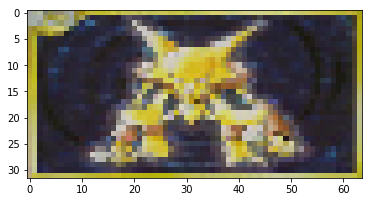

In [11]:
example_input = x[0]
generator_dense_output_size = int(tf.reduce_prod(example_input.shape))
generator_output_size = example_input.shape

plt.imshow(tf.squeeze(x[0]), cmap='gray')

# Loss functions

In [12]:
def generator_loss(ytrue, ypred):   
    return -tf.reduce_sum(ypred)

def discriminator_loss(ytrue, ypred):
    is_fake = tf.equal(ytrue[:, -1], 1.0)
        
    return tf.reduce_sum(tf.where(is_fake, ypred, -ypred))

# Generator

In [13]:
def make_generator_input(n_records, given_labels: dict = None):
    x = tf.random.normal((n_records, n_generator_input))
    return x

assert make_generator_input(10).shape[1] == n_generator_input

In [14]:
generator_conv_sizes = [6, 3, 1]
generator_init_height = generator_output_size[0].value
generator_init_width = generator_output_size[1].value
generator_init_channels = 40
generator_filters = 100
generator_upsampling = [2, 2, 1]

for sampling, conv_size in zip(reversed(generator_upsampling), reversed(generator_conv_sizes)):
    print(f"{conv_size} --- \twidth: {generator_init_width}\t height: {generator_init_height}")
    generator_init_width = (generator_init_width - (conv_size - 1)) / sampling
    generator_init_height = (generator_init_height - (conv_size - 1)) / sampling
    
print(f"{conv_size} --- \twidth: {generator_init_width}\t height: {generator_init_height}")
assert int(generator_init_width) == generator_init_width and int(generator_init_height) == generator_init_height
generator_init_width = int(generator_init_width)
generator_init_height = int(generator_init_height)

generator_last_dense_layer = generator_init_height * generator_init_channels * generator_init_width

1 --- 	width: 64	 height: 32
3 --- 	width: 64.0	 height: 32.0
6 --- 	width: 31.0	 height: 15.0
6 --- 	width: 13.0	 height: 5.0


In [15]:
generator_input = keras.layers.Input((n_generator_input,))
gen_x = keras.layers.Dropout(.5)(generator_input)
gen_x = keras.layers.Dense(n_generator_dense)(gen_x)
gen_x = keras.layers.LeakyReLU()(gen_x)
gen_x = keras.layers.Dense(n_generator_dense)(gen_x)
gen_x = keras.layers.LeakyReLU()(gen_x)
gen_x = keras.layers.Dense(generator_last_dense_layer)(gen_x)
gen_x = keras.layers.LeakyReLU()(gen_x)
gen_x = keras.layers.Reshape((generator_init_height, generator_init_width, generator_init_channels))(gen_x)


for i, (conv_size, upsampling) in enumerate(zip(generator_conv_sizes, generator_upsampling)):
    if i < len(generator_conv_sizes) - 1:
        act = "relu"
        filters=generator_filters
    else:
        act = "sigmoid"
        filters= 1 if use_greyscale else 3
    
    if upsampling > 1:
        gen_x = keras.layers.UpSampling2D(size=upsampling)(gen_x)
    gen_x = keras.layers.Conv2DTranspose(
        filters=filters, 
        kernel_size=conv_size,
        activation=act,
    )(gen_x)
    
generator = keras.Model(generator_input, gen_x)

In [16]:
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 200)               20200     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2600)              522600

In [17]:
assert generator.predict(make_generator_input(1)).shape == tf.expand_dims(example_input, 0).shape

# Minibatch Discrimination

In [18]:
# Failed implementation

# class MinibatchDiscrimination(keras.layers.Layer):
#     def __init__(self, nb_kernels, kernel_dim, init='glorot_uniform', **kwargs):
#         super(MinibatchDiscrimination, self).__init__(**kwargs)
#         self.init = keras.initializers.get(init)
#         self.nb_kernels = int(nb_kernels)
#         self.kernel_dim = int(kernel_dim)

#     def build(self, input_shape):
#         self.kernel = self.add_variable(
#             shape=(self.nb_kernels, int(input_shape[-1]), self.kernel_dim),
#             name=f"{self.name}_W",
#         )
        
#     def good_call(self, input):
#         dotprod = keras.backend.dot(x, self.kernel)
#         activation = keras.backend.reshape(dotprod, (-1, self.nb_kernels, self.kernel_dim))
#         diffs = keras.backend.expand_dims(activation, 3) - keras.backend.expand_dims(keras.backend.permute_dimensions(activation, [1, 2, 0]), 0)
#         abs_diffs = keras.backend.sum(keras.backend.abs(diffs), axis=2)
#         minibatch_features = keras.backend.sum(keras.backend.exp(-abs_diffs), axis=2)
#         return keras.backend.concatenate([x, minibatch_features], 1)

#     def call(self, input):
#         T = tf.einsum('ij,kjl->ikl', input, self.kernel) # input - B - C
        
#         r = tf.reduce_sum(T*T, -1)
#         Tij = 2 * tf.einsum("ijk,ljk->ilj", T, T)
        
#         D = tf.expand_dims(r, axis=1) - Tij + tf.expand_dims(r, axis=0)
        
#         dissimilarities = tf.reduce_sum(tf.math.sqrt(tf.abs(D)), 1)
        
#         res = tf.concat((input, dissimilarities), axis=-1)
        
#         print(res)
#         print(self.good_call(input))
#         print("----\n----\n----\n")
        
#         return res

In [19]:

class MinibatchDiscrimination(keras.layers.Layer):
    """Concatenates to each sample information about how different the input
    features for that sample are from features of other samples in the same
    minibatch, as described in Salimans et. al. (2016). Useful for preventing
    GANs from collapsing to a single output. When using this layer, generated
    samples and reference samples should be in separate batches.
    # Example
    ```python
        # apply a convolution 1d of length 3 to a sequence with 10 timesteps,
        # with 64 output filters
        model = Sequential()
        model.add(Convolution1D(64, 3, border_mode='same', input_shape=(10, 32)))
        # now model.output_shape == (None, 10, 64)
        # flatten the output so it can be fed into a minibatch discrimination layer
        model.add(Flatten())
        # now model.output_shape == (None, 640)
        # add the minibatch discrimination layer
        model.add(MinibatchDiscrimination(5, 3))
        # now model.output_shape = (None, 645)
    ```
    # Arguments
        nb_kernels: Number of discrimination kernels to use
            (dimensionality concatenated to output).
        kernel_dim: The dimensionality of the space where closeness of samples
            is calculated.
        init: name of initialization function for the weights of the layer
            (see [initializations](../initializations.md)),
            or alternatively, Theano function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
        weights: list of numpy arrays to set as initial weights.
        W_regularizer: instance of [WeightRegularizer](../regularizers.md)
            (eg. L1 or L2 regularization), applied to the main weights matrix.
        activity_regularizer: instance of [ActivityRegularizer](../regularizers.md),
            applied to the network output.
        W_constraint: instance of the [constraints](../constraints.md) module
            (eg. maxnorm, nonneg), applied to the main weights matrix.
        input_dim: Number of channels/dimensions in the input.
            Either this argument or the keyword argument `input_shape`must be
            provided when using this layer as the first layer in a model.
    # Input shape
        2D tensor with shape: `(samples, input_dim)`.
    # Output shape
        2D tensor with shape: `(samples, input_dim + nb_kernels)`.
    # References
        - [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498)
    """

    def __init__(self, nb_kernels, kernel_dim, init='glorot_uniform', weights=None,
                 W_regularizer=None, activity_regularizer=None,
                 W_constraint=None, input_dim=None, **kwargs):
        self.init = keras.initializers.get(init)
        self.nb_kernels = nb_kernels
        self.kernel_dim = kernel_dim
        self.input_dim = input_dim

        self.W_regularizer = keras.regularizers.get(W_regularizer)
        self.activity_regularizer = keras.regularizers.get(activity_regularizer)

        self.W_constraint = keras.constraints.get(W_constraint)

        self.initial_weights = weights
        self.input_spec = [keras.layers.InputSpec(ndim=2)]

        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)
        super(MinibatchDiscrimination, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
#         self.input_spec = [keras.layers.InputSpec(dtype=keras.backend.floatx,
#                                      shape=(None, input_dim))]
        self.W = self.init(
            (self.nb_kernels, input_dim, self.kernel_dim),
#             name='{}_W'.format(self.name)
        )

#         self.trainable_weights = [self.W]

        self.regularizers = []
        if self.W_regularizer:
            self.W_regularizer.set_param(self.W)
            self.regularizers.append(self.W_regularizer)

        if self.activity_regularizer:
            self.activity_regularizer.set_layer(self)
            self.regularizers.append(self.activity_regularizer)

        self.constraints = {}
        if self.W_constraint:
            self.constraints[self.W] = self.W_constraint

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights

    def call(self, x, mask=None):
        activation = keras.backend.reshape(keras.backend.dot(x, self.W), (-1, self.nb_kernels, self.kernel_dim))
        diffs = keras.backend.expand_dims(activation, 3) - keras.backend.expand_dims(keras.backend.permute_dimensions(activation, [1, 2, 0]), 0)
        abs_diffs = keras.backend.sum(keras.backend.abs(diffs), axis=2)
        minibatch_features = keras.backend.sum(keras.backend.exp(-abs_diffs), axis=2)
        return keras.backend.concatenate([x, minibatch_features], 1)

    def get_output_shape_for(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], input_shape[1]+self.nb_kernels

    def get_config(self):
        config = {'nb_kernels': self.nb_kernels,
                  'kernel_dim': self.kernel_dim,
                  'init': self.init.__name__,
                  'W_regularizer': self.W_regularizer.get_config() if self.W_regularizer else None,
                  'activity_regularizer': self.activity_regularizer.get_config() if self.activity_regularizer else None,
                  'W_constraint': self.W_constraint.get_config() if self.W_constraint else None,
                  'input_dim': self.input_dim}
        base_config = super(MinibatchDiscrimination, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [20]:
def test_minibatch():
    n = 12
    nvar = 4
    B = 6
    C = 7
    A = tf.random.normal((n, nvar))
    l = MinibatchDiscrimination(B, C)
    l.build(A.shape)
    assert l.call(A).shape == (n, nvar + B)
    
test_minibatch()

# Discriminator

In [21]:
discr_dense_size = 200
discr_minibatch_features = int(discr_dense_size / 10)
disc_C = 20

inputs = keras.layers.Input(shape=generator_output_size)
x_1 = keras.layers.Dropout(.5, input_shape=generator_output_size)(inputs)
x_1 = keras.layers.Conv2D(filters=60, kernel_size=5, strides=1, input_shape=generator_output_size)(x_1)
x_1 = keras.layers.MaxPool2D()(x_1)
x_1 = keras.layers.Conv2D(filters=40, kernel_size=5, strides=1)(x_1)
x_1 = keras.layers.MaxPool2D()(x_1)
# x_1 = keras.layers.Conv2D(filters=40, kernel_size=5, strides=1)(x_1)
# x_1 = keras.layers.MaxPool2D()(x_1)
x_1 = keras.layers.Flatten()(x_1)
x_1 = keras.layers.Dense(units=discr_dense_size)(x_1)
x_1 = keras.layers.LeakyReLU()(x_1)

x_1 = MinibatchDiscrimination(discr_minibatch_features, disc_C)(x_1)
x_1 = keras.layers.BatchNormalization()(x_1)

x_1 = keras.layers.Dense(units=discr_dense_size)(x_1)
x_1 = keras.layers.LeakyReLU()(x_1)

x_1 = MinibatchDiscrimination(discr_minibatch_features, disc_C)(x_1)
x_1 = keras.layers.BatchNormalization()(x_1)

    
output = keras.layers.Dense(units=1)(x_1)

discriminator = keras.Model(inputs, output, name="discriminator")

discriminator.compile(
    optimizer=keras.optimizers.Nadam(learning_rate=.001),
    loss=discriminator_loss,
    metrics=[keras.metrics.CategoricalAccuracy()],
)
discriminator.trainable = False

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [22]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 64, 3)]       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 60, 60)        4560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 30, 60)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 26, 40)        60040     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 13, 40)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2600)            

# Generator training model

In [23]:
generator_trainer = keras.Model(
    generator_input,
    discriminator(generator(generator_input)), 
)

generator_trainer.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model (Model)                (None, 32, 64, 3)         817503    
_________________________________________________________________
discriminator (Model)        (None, 1)                 630981    
Total params: 1,448,484
Trainable params: 817,503
Non-trainable params: 630,981
_________________________________________________________________


In [24]:
generator_trainer.compile(
    optimizer=keras.optimizers.Nadam(learning_rate=.001),
    loss=generator_loss,
    metrics=[keras.metrics.CategoricalAccuracy()],
)

In [25]:
random_input = make_generator_input(1)
test_predict = generator_trainer.predict(random_input)

assert output.shape[1] == 1

# Training

In [26]:
# Intionally swapped tradidtion fake/real labels
def make_fake_label(n_records):
    return make_label(n_records, 0, 0)

def make_real_label(n_records):
    return make_label(n_records, 1, 1)

def make_label(n_records, min_, max_):
    return tf.random.uniform(shape=(n_records, 1), minval=min_, maxval=max_)

# Pretrain discriminator

In [27]:
def train_discriminator(
    epochs,
    n_real=n_real_per_training,
    n_fake=n_random_inputs_per_training,
    
):
    with_real = n_real > 0
    with_fake = n_fake > 0 
    
    if with_fake:
        generator_x = make_generator_input(n_fake)
        generated_input = generator.predict(generator_x)
        generator_y_fake = make_fake_label(n_fake)

    if with_real:
        if n_real == x.shape[0]:
            real_x = x
        else:
            real_indices = np.random.randint(size=(n_real, 1), low=0, high=n_records)
            real_x = tf.squeeze(tf.gather(x, real_indices))
        real_y = make_real_label(n_real)
    
    if with_real and with_fake:
        discriminator_x = tf.concat((real_x, generated_input), axis=0)
        discriminator_y = tf.concat((real_y, generator_y_fake), axis=0)
    elif with_real:
        discriminator_x = real_x
        discriminator_y = real_y
    elif with_fake:
        discriminator_x = generated_input
        discriminator_y = generator_y_fake
        
    discriminator.fit(discriminator_x, discriminator_y, epochs=epochs, shuffle=False, batch_size=batch_size)

# Train generator

In [28]:
def plot_images_and_classes(n):
    inputs = make_generator_input(n)
    predictions = generator.predict(inputs)
    
    for i in range(n):
        img = predictions[i]        
        plt.imshow(img)
        plt.show()


In [29]:
def train_generator(
    epochs: int,
    n_fake = n_random_inputs_per_training,
):
    generator_x = make_generator_input(n_fake)
    generator_y = make_real_label(n_fake)
        
    generator_trainer.fit(generator_x, generator_y, epochs=epochs, batch_size=batch_size)

In [30]:
gc.collect()
try:
    for i in range(n_epochs):
        print(f"{i} / {n_epochs}")

        # discriminator
        train_discriminator(2, n_fake=n_random_inputs_per_training, n_real=n_real_per_training)
        gc.collect()
        
        # generator
        train_generator(2, n_fake=n_random_inputs_per_training)
        gc.collect()
        
        plot_images_and_classes(1)
finally:
    gc.collect()

0 / 200
Epoch 1/2
6000/6000 [==============================] - 2s 405us/sample - loss: 1.3786 - categorical_accuracy: 1.0000
Epoch 2/2
6000/6000 [==============================] - 2s 287us/sample - loss: -20.2769 - categorical_accuracy: 1.0000
Epoch 1/2


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument: You must feed a value for placeholder tensor 'input_2' with dtype float and shape [?,32,64,3]
	 [[{{node input_2}}]]
	 [[discriminator/dropout_1/cond/then/_8/dropout/Cast/_18]]
  (1) Invalid argument: You must feed a value for placeholder tensor 'input_2' with dtype float and shape [?,32,64,3]
	 [[{{node input_2}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_keras_scratch_graph_313648]

In [ ]:
gc.collect()

# Test a couple of records

In [ ]:
plot_images_and_classes(5)

In [ ]:
try:
    train_generator(10, 2000)
finally:
    gc.collect()